In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [167]:
music_mental_health = pd.read_csv("data/mxmh_survey_results.csv")
music_mental_health.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


# Data Exploration

I first wanted to know how many entries were in my entire data frame. I knew the data set was a survey conducted by an undergraduate student, and so I had assumed that there wouldn't be a huge number of entries. I used len() to check the size, and there was a decent amount of data. Now, I just wanted to first get an overview of how many NA values there were in total for the entire data set. If there weren't a lot, I would just drop them, but if there were a lot, I wanted to know which columns contained the most. I used isna() and then counted them using numpy count_nonzero, and there were 129 NA values in the data set. That was a lot considering my data set only had 736 entries, so next I used isnull() and summed that to see the total NA values for each column. I wanted to identify if there was a particular column that contained most of the NA values, and I found BPM contained a majority of them. Knowing that I will not be using this column for my analysis, I can just drop it and then drop the remaining rows that had NA values in other columns I need, and I know I will only be dropping around 10-15 NA values, which is much smaller than 129 and is not a significant portion of my data set. 

In [170]:
# Checking how many entries in my data frame
len(music_mental_health)

736

In [171]:
# How many entries are NA
np.count_nonzero(music_mental_health.isna())

129

In [172]:
# Check how many NA in each column
music_mental_health.isnull().sum()

Timestamp                         0
Age                               1
Primary streaming service         1
Hours per day                     0
While working                     3
Instrumentalist                   4
Composer                          1
Fav genre                         0
Exploratory                       0
Foreign languages                 4
BPM                             107
Frequency [Classical]             0
Frequency [Country]               0
Frequency [EDM]                   0
Frequency [Folk]                  0
Frequency [Gospel]                0
Frequency [Hip hop]               0
Frequency [Jazz]                  0
Frequency [K pop]                 0
Frequency [Latin]                 0
Frequency [Lofi]                  0
Frequency [Metal]                 0
Frequency [Pop]                   0
Frequency [R&B]                   0
Frequency [Rap]                   0
Frequency [Rock]                  0
Frequency [Video game music]      0
Anxiety                     

In [173]:
# I want to be able to keep the original data frame just how it is in case I need it 
# so I will create a new data frame that will be the one I change. mmh_clean (music_mental_health_clean).

# Dropping NA values
mmh_clean = music_mental_health.dropna()
# check that it worked
mmh_clean.isnull().sum()

Timestamp                       0
Age                             0
Primary streaming service       0
Hours per day                   0
While working                   0
Instrumentalist                 0
Composer                        0
Fav genre                       0
Exploratory                     0
Foreign languages               0
BPM                             0
Frequency [Classical]           0
Frequency [Country]             0
Frequency [EDM]                 0
Frequency [Folk]                0
Frequency [Gospel]              0
Frequency [Hip hop]             0
Frequency [Jazz]                0
Frequency [K pop]               0
Frequency [Latin]               0
Frequency [Lofi]                0
Frequency [Metal]               0
Frequency [Pop]                 0
Frequency [R&B]                 0
Frequency [Rap]                 0
Frequency [Rock]                0
Frequency [Video game music]    0
Anxiety                         0
Depression                      0
Insomnia      

Before I started exploring some of the variables visually, I wanted to verify all my data types and ensure they appeared as expected. First thing I noticed was that Timestamp is an object, not a datetime, but I will not be using this, so it won't matter. Everything else looks as expected, so I will not change any data types and will proceed with visualization. 

In [175]:
mmh_clean.dtypes

Timestamp                        object
Age                             float64
Primary streaming service        object
Hours per day                   float64
While working                    object
Instrumentalist                  object
Composer                         object
Fav genre                        object
Exploratory                      object
Foreign languages                object
BPM                             float64
Frequency [Classical]            object
Frequency [Country]              object
Frequency [EDM]                  object
Frequency [Folk]                 object
Frequency [Gospel]               object
Frequency [Hip hop]              object
Frequency [Jazz]                 object
Frequency [K pop]                object
Frequency [Latin]                object
Frequency [Lofi]                 object
Frequency [Metal]                object
Frequency [Pop]                  object
Frequency [R&B]                  object
Frequency [Rap]                  object


I first wanted to look at the distribution of age. I know the survey was conducted by an undergraduate student at the University of Washington, so I figured that there would be mostly college-aged respondents. The mode of the distribution is around 20, but there is actually a right skew, and there is one data point towards 90 that could be an outlier or possibly a mistake; further exploration on that might be needed. There is a large spread in the data, but it does appear that the majority of the data is from younger respondents.

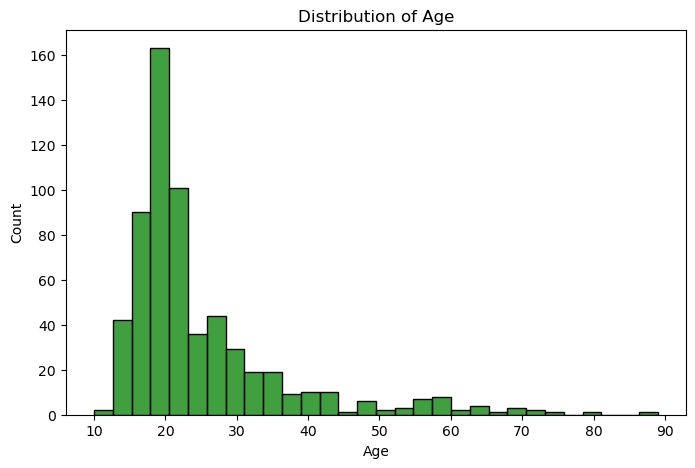

In [177]:
plt.figure(figsize=(8,5))

sns.histplot(mmh_clean, x = "Age", color = "green", bins = 30)

plt.title("Distribution of Age");

In [178]:
# Just as a quick check I wanted to know the exact spread of the data so I used the min() and max() functions to check the age column.
min_age = mmh_clean["Age"].min()
max_age = mmh_clean["Age"].max()

print(min_age, max_age)

10.0 89.0


Next, I made a histogram to look at the distribution of the hours per day people listen to music. I changed the bin size because there were some holes in the plot. The mode of the distribution is around 3 hours per day, and most of the distribution is around 0-10 hours per day. There is also a large spread for the hours per day variable; the distribution is right-skewed with a right tail. There is one observation that looks to be around 24 hours a day, so this could be an outlier or a mistake, but further exploration would be needed. 

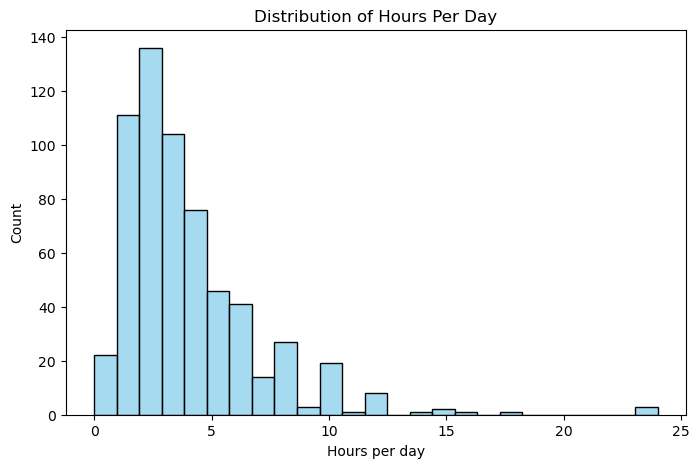

In [180]:
plt.figure(figsize=(8,5))

sns.histplot(mmh_clean, x = "Hours per day", color = "skyblue", bins = 25)
plt.title("Distribution of Hours Per Day");

In [181]:
# Again, just wanted to look at the exact spread. Someone listens to music 24 hours a day!
min_age = mmh_clean["Hours per day"].min()
max_age = mmh_clean["Hours per day"].max()

print(min_age, max_age)

0.0 24.0


I wanted to do some more descriptive statistics on the two numerical variables I have. The first one describes the age variable. The average age is around 24, which seems as expected. The second block describes the hours per day variable; the average hours per day is 3.7, which also seems as expected. The most notable things for this distribution are the same as I saw in the visualizations; the spread for both variables is very large, possibly indicating outliers or mistakes. In particular, the hours per day variable 75% of the data listens to 5 hours or less of music, which makes 24 hours seem even more unrealistic.  

In [183]:
display(
    mmh_clean["Age"].describe(),
    mmh_clean["Hours per day"].describe()
)

count    616.000000
mean      24.792208
std       11.658515
min       10.000000
25%       18.000000
50%       21.000000
75%       27.000000
max       89.000000
Name: Age, dtype: float64

count    616.000000
mean       3.702435
std        3.071961
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       24.000000
Name: Hours per day, dtype: float64

Now I want to look at some of the other categorical columns we have. To start, I just want to look at the streaming services people use. I'll start by just looking at the frequencies of each streaming service in the data set. It appears that Spotify and YouTube Music are the most frequently used by these respondents, which is not what I would have expected. Apple Music is actually not a very popular streaming service for these respondents, which I did not expect. Some people do not use a streaming service, which could correlate to the people who said they listen to 0 hours of music per day, or they possibly listen to the radio, CDs, or vinyls (fun!!). 

In [185]:
# Using value counts to look at the frequencies of streaming services. Setting normalize=True gives proportions.
mmh_clean["Primary streaming service"].value_counts(normalize=True)

Primary streaming service
Spotify                              0.642857
YouTube Music                        0.118506
I do not use a streaming service.    0.090909
Apple Music                          0.068182
Other streaming service              0.064935
Pandora                              0.014610
Name: proportion, dtype: float64

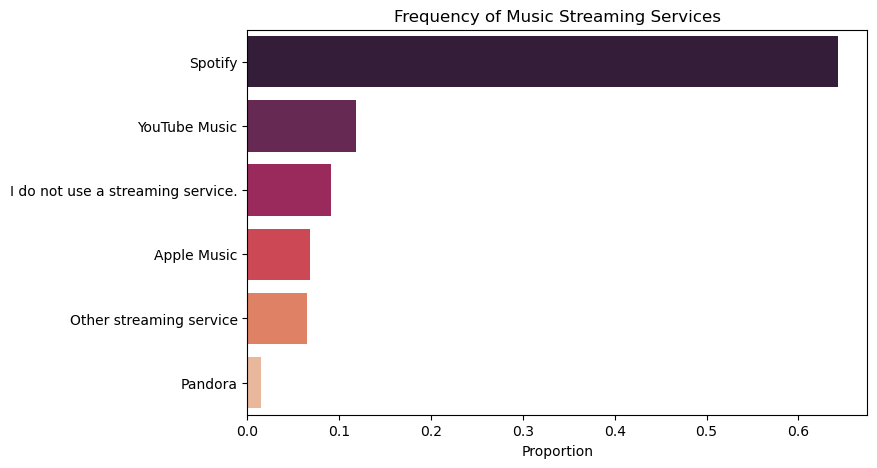

In [186]:
# A quick visualization of these proportions using a bar chart.
plt.figure(figsize=(8,5))

prop_streaming = mmh_clean["Primary streaming service"].value_counts(normalize=True).reset_index()
sns.barplot(prop_streaming, x = "proportion", y = "Primary streaming service", 
            hue = "Primary streaming service", palette = "rocket")

plt.title("Frequency of Music Streaming Services")
plt.xlabel("Proportion")
plt.ylabel(None);

The next categorical variables I want to look at are the frequency of music genres. The options for respondents were "Very Frequently", "Sometimes", "Rarely", and "Never" for each genre of music (classical, Country, EDM, Folk, Gospel, Hip hop, Jazz, Kpop, Latin, Lofi, Metal, Pop, R&B, Rap, Rock, and Video game music). First thing I want to do is change the column names because the current set up is not super helpful.

In [188]:
# First creating a dictionary of the column names and the replacement names
column_names = {"Frequency [Classical]": "Classical",
                "Frequency [Country]": "Country",
                "Frequency [EDM]": "EDM",
                "Frequency [Folk]": "Folk",
                "Frequency [Gospel]": "Gospel",
                "Frequency [Hip hop]": "Hip hop",
                "Frequency [Jazz]": "Jazz",
                "Frequency [K pop]": "Kpop",
                "Frequency [Latin]": "Latin",
                "Frequency [Lofi]": "Lofi",
                "Frequency [Metal]": "Metal",
                "Frequency [Pop]": "Pop",
                "Frequency [R&B]": "R&B",
                "Frequency [Rap]": "Rap",
                "Frequency [Rock]": "Rock",
                "Frequency [Video game music]": "Video game music"}
#Using the rename() function to rename the columns and modify the current data frame by using inplace=True
mmh_clean.rename(columns=column_names, inplace=True)
# Check that the columns were renamed as expected
mmh_clean.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3743958929.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmh_clean.rename(columns=column_names, inplace=True)


,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,R&B,Rap,Rock,Video game music,Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.
5,8/27/2022 21:56:50,18.0,Spotify,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,...,Very frequently,Very frequently,Very frequently,Never,8.0,8.0,7.0,7.0,Improve,I understand.
6,8/27/2022 22:00:29,18.0,YouTube Music,3.0,Yes,Yes,No,Video game music,Yes,Yes,...,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,Improve,I understand.


In [189]:
# Subset my current data frame so that I just have the genres. This will be easier to work with. 
genre_df = mmh_clean[["Classical", "Country", "EDM", "Folk", "Gospel", 
"Hip hop", "Jazz", "Kpop", "Latin", "Lofi", "Metal", "Pop", "R&B", "Rap", "Rock", "Video game music"]]
# Checking it looks how expected.
genre_df.head()

# Now melting the data into long format for plotting
genre_melted = genre_df.melt(var_name = "Genre", value_name = "Frequency")
#genre_melted #(was checking that it melted as expected but don't need)

In [190]:
# Using groupby() and value_counts() to take the proportion of each response for each genre and put it in a new df genre_props
genre_props = genre_melted.groupby("Genre").value_counts(normalize=True).reset_index()
genre_props.head() # Here's a check, looks good!

,Genre,Frequency,proportion
0,Classical,Rarely,0.362013
1,Classical,Sometimes,0.272727
2,Classical,Never,0.225649
3,Classical,Very frequently,0.139610
4,Country,Never,0.470779


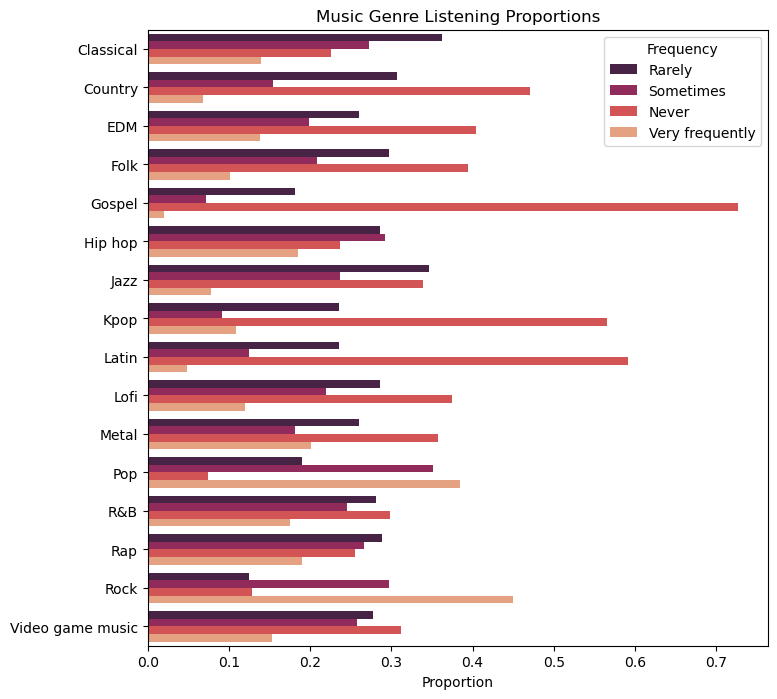

In [191]:
plt.figure(figsize=(8,8))
sns.barplot(genre_props, x = "proportion", y = "Genre", hue = "Frequency", palette = "rocket") #maybe change pallete

plt.title("Music Genre Listening Proportions")
plt.xlabel("Proportion")
plt.ylabel(None);

I created a paired bar plot to look at the proportion of answers for each genre to examine which genres are more commonly listened to. Interestingly, there is a pretty wide spread of music genres that people listen to in this survey. There are some genres like Gospel, Latin, and K-pop, which are less popular than other genres like Pop, Rap, and Hip hop. It's helpful to know that at least visually, the spread of genres is relatively even. Next, I took the proportion of each genre for each answer in the survey just to further explore the popularity of each genre visually. This bar plot confirmed what I saw previously, that Gospel, Latin, and Kpop are less popular, and pop is the most popular. 

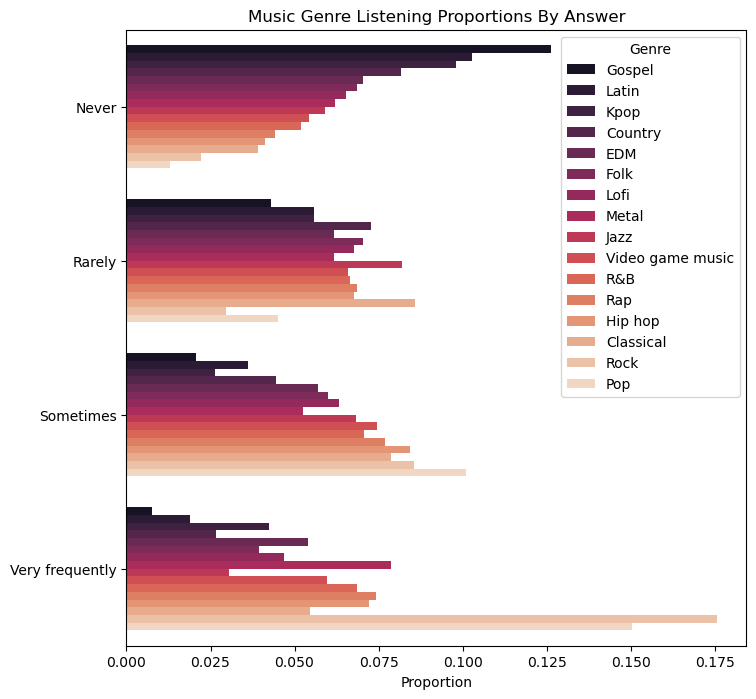

In [193]:
# Calculating the proportion of genres for each answer on the survey.
freq_props = genre_melted.groupby("Frequency").value_counts(normalize=True).reset_index()

plt.figure(figsize=(8,8))
sns.barplot(freq_props, x = "proportion", y = "Frequency", hue = "Genre", palette = "rocket") #maybe change pallete

plt.title("Music Genre Listening Proportions By Answer")
plt.xlabel("Proportion")
plt.ylabel(None);

In [194]:
mental_health = mmh_clean[["Anxiety", "Depression", "Insomnia", "OCD"]]
mental_health.head()

,Anxiety,Depression,Insomnia,OCD
2,7.0,7.0,10.0,2.0
3,9.0,7.0,3.0,3.0
4,7.0,2.0,5.0,9.0
5,8.0,8.0,7.0,7.0
6,4.0,8.0,6.0,0.0


The last variable I wanted to explore was the mental health columns I have in my data set. The columns are anxiety, depression, insomnia, and OCD. First, I created a box plot to look at the distribution of all the columns. Anxiety had the highest median ranking, and OCD had the lowest. Then I just took the median and mean of each column to look more closely; their median and means are all very close, with people ranking anxiety around a 6 on average. This seems as expected, as anxiety is a common disorder and many people in their 20s-30s experience a lot of stress and anxiety.

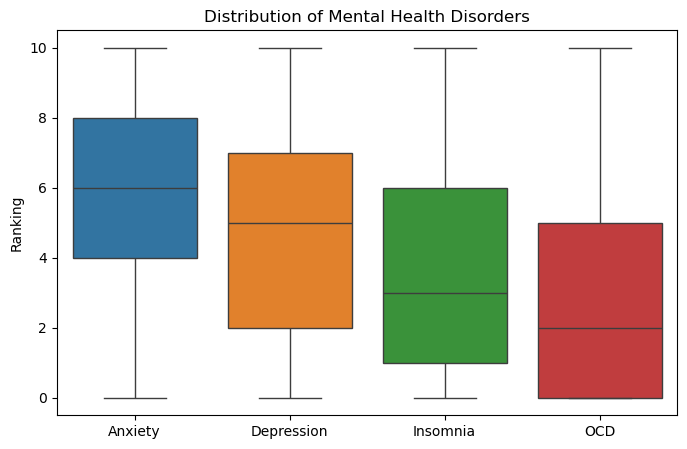

In [196]:
plt.figure(figsize=(8,5))

sns.boxplot(mental_health)
plt.title("Distribution of Mental Health Disorders")
plt.ylabel("Ranking");

In [197]:
display(mental_health.median(),
mental_health.mean())

Anxiety       6.0
Depression    5.0
Insomnia      3.0
OCD           2.0
dtype: float64

Anxiety       5.883929
Depression    4.894481
Insomnia      3.801136
OCD           2.659091
dtype: float64

# Inference

I wanted to look at the anxiety column of my data set. I think anxiety is something a lot of people experience, especially people in their 20s-30s, so I thought it would be interesting to explore this column. The Anxiety column also had the highest self-scoring out of all the mental health disorders in the data set, so I thought this would work well. My first thought was to explore how different music genres affected anxiety scoring, or if there was any effect at all. I chose three genres: rock, metal, and lofi. I chose rock and metal because those tend to be more emotionally intense, and lofi because that's a bit more chill, and classical did not have a lot of listeners. My question is, "Does the genre of music people listen to most frequently change their anxiety scoring?" My null hypothesis will be that listening to certain genres of music has no effect on people's anxiety, and the alternative hypothesis will be that listening to certain genres will change a person's anxiety. I think that rock and metal might show higher scores of anxiety, while lofi might show lower, because intense music might affect someone's ability to emotionally regulate. 

### Question: Does music genre listening frequency change anxiety scores?

### Null Hypothesis: Listening to certain genres of music does not affect people's anxiety
### Alternative Hypothesis: Listening to certain genres os music will affect a person's anxiety

#### Rock

In [203]:
# Select only the anxiety column and Rock column to create a data frame with just the two target variables
rock_genre = mmh_clean[["Rock", "Anxiety"]]
rock_genre.head()

,Rock,Anxiety
2,Rarely,7.0
3,Never,9.0
4,Never,7.0
5,Very frequently,8.0
6,Never,4.0


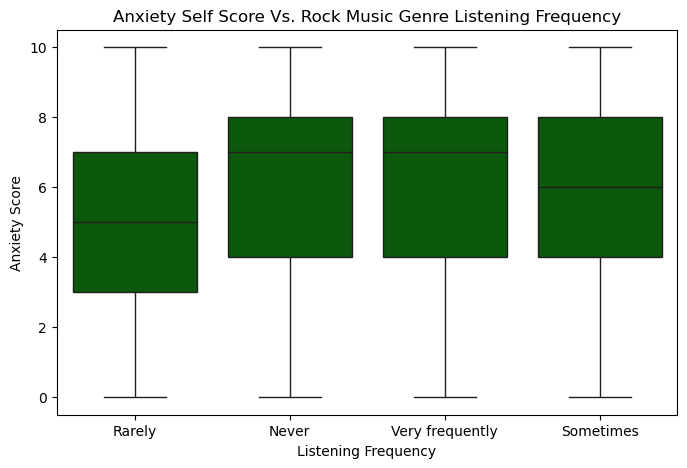

In [204]:
# Plotting the association between Rock and Anxiety using a boxplot
plt.figure(figsize=(8,5))

sns.boxplot(rock_genre, x = "Rock", y = "Anxiety", color = "darkgreen")
plt.title("Anxiety Self Score Vs. Rock Music Genre Listening Frequency")
plt.xlabel("Listening Frequency")
plt.ylabel("Anxiety Score");

The boxplots for the association between how often people listen to rock and their anxiety scores do not show much difference. The box for people who rarely or sometimes listen to rock shows a slightly lower median than never or very frequently listen to rock. Interestingly, the range of scores for people who rarely listen to rock is lower than people who never listen to rock.

In [206]:
# Replace the categorical values with 0-3 for linear regression
rock_genre["Rock"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
rock_genre.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/1793732382.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rock_genre["Rock"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/1793732382.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavi

,Rock,Anxiety
2,1,7.0
3,0,9.0
4,0,7.0
5,3,8.0
6,0,4.0


In [207]:
# Assign X and y 
X_1 = rock_genre[["Rock"]]
y_1 = rock_genre["Anxiety"]

# Fit the model using sklearn
lm_1 = LinearRegression()
lm_fit_1 = lm_1.fit(X_1, y_1)

In [208]:
# Find coefficient
lm_fit_1.coef_

array([0.15945016])

In [209]:
# Find intercept
lm_fit_1.intercept_

5.554156649373655

In [210]:
# Full regression results
X_1_sm = sm.add_constant(X_1)

lin_reg_1 = sm.OLS(y_1, X_1_sm).fit()
lin_reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Anxiety   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.234
Date:                Fri, 05 Dec 2025   Prob (F-statistic):              0.136
Time:                        00:01:46   Log-Likelihood:                -1497.4
No. Observations:                 616   AIC:                             2999.
Df Residuals:                     614   BIC:                             3008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5542      0.247     22.487      0.000       5.069       6.039
Rock           0.1595      0.107      1.495      0.136      -0.050       0.369
==============================================================================
Omnibus:                       48.995   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.293
Skew:                          -0.424   Prob(JB):                     1.60e-07
Kurtosis:                       2.292   Cond. No.                         5.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model for the rock genre showed only a small increase in anxiety score based on an increase in listening frequency. The coefficient or slope for the model was 0.159, which is an increase from never listening to rock all the way to very frequently listening to rock, only increases anxiety scores by less than half a point; this is a very small effect on a scale from 1-10. The R2 value was 0.004, meaning that listening to rock music explained 0.4% of the variance in anxiety scores; therefore, there are likely other factors influencing anxiety scores. Supporting this was that our p-value was 0.136, which is greater than 0.05, and therefore we fail to reject the null that the frequency a person listens to rock music affects their anxiety scores. We can also see that our confidence interval is from -0.050 to 0.369, meaning that we are not confident that listening to rock music has a negative, neutral, or positive effect on anxiety scores. 

#### Metal

In [213]:
# Selecting just the Metal and Anxiety columns to make a data frame of just the variables I want to look at
metal_genre = mmh_clean[["Metal", "Anxiety"]]
metal_genre.head()

,Metal,Anxiety
2,Sometimes,7.0
3,Never,9.0
4,Never,7.0
5,Rarely,8.0
6,Rarely,4.0


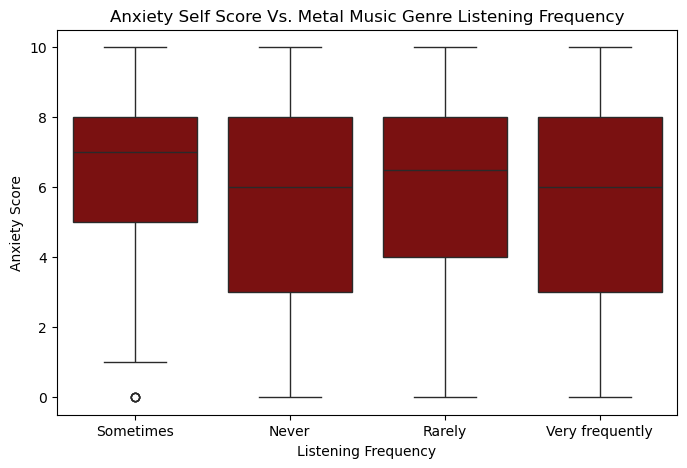

In [214]:
# Plotting the association between Metal and Anxiety using a boxplot
plt.figure(figsize=(8,5))

sns.boxplot(metal_genre, x = "Metal", y = "Anxiety", color = "darkred")
plt.title("Anxiety Self Score Vs. Metal Music Genre Listening Frequency")
plt.xlabel("Listening Frequency")
plt.ylabel("Anxiety Score");

The boxplot for the frequency that people listen to metal and their anxiety scores shows little difference in its distribution, like the rock plot. In this plot, people who sometimes and rarely listen to metal have a higher median anxiety score than those who never or very frequently listen to metal. The range of the never and very frequent listeners is also larger than those who listen sometimes or rarely. The people who listen sometimes also appear to have a possible outlier at zero.

In [216]:
# Replacing categorical values with 0-3 to use for linear regression
metal_genre["Metal"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
metal_genre.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3565545354.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metal_genre["Metal"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3565545354.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beha

,Metal,Anxiety
2,2,7.0
3,0,9.0
4,0,7.0
5,1,8.0
6,1,4.0


In [217]:
# Assign X and y for regression
X_2 = metal_genre[["Metal"]]
y_2 = metal_genre["Anxiety"]

# Create linear model
lm_2 = LinearRegression()
lm_fit_2 = lm_2.fit(X_2, y_2) # Fit model

In [218]:
# Coefficient/slope
lm_fit_2.coef_

array([0.06311372])

In [219]:
# Intecept term
lm_fit_2.intercept_

5.806470818516948

In [220]:
# Full regression summary
X_2_sm = sm.add_constant(X_2)

lin_reg_2 = sm.OLS(y_2, X_2_sm).fit()
lin_reg_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Anxiety   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4165
Date:                Fri, 05 Dec 2025   Prob (F-statistic):              0.519
Time:                        00:01:47   Log-Likelihood:                -1498.4
No. Observations:                 616   AIC:                             3001.
Df Residuals:                     614   BIC:                             3010.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8065      0.164     35.489      0.000       5.485       6.128
Metal          0.0631      0.098      0.645      0.519      -0.129       0.255
==============================================================================
Omnibus:                       51.129   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.783
Skew:                          -0.423   Prob(JB):                     1.25e-07
Kurtosis:                       2.278   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Similar to the rock model, metal had a minimal effect on the anxiety score, even smaller than rock. With each increase in rock listening frequency, there was a 0.063 increase in anxiety scores; this is extremely small on a scale of 0-10 and is close to no effect at all. In addition, the frequency a person listens to metal only explained 0.001 or 0.1% of the variance in anxiety scores, which is extremely low. This can be seen in our p-value, which was 0.519, and we fail to reject the null hypothesis that the frequency a person listens to metal music does not affect their anxiety score. Our confidence interval also shows this relationship with 95% confidence between -0.129 and 0.255, meaning we are not confident in the effect listening to metal has on anxiety scores.

#### Lofi

In [223]:
# Selecting the final music genre I want to look at and putting it into a data frame with the Anxiety column
lofi_genre = mmh_clean[["Lofi", "Anxiety"]]
lofi_genre.head()

,Lofi,Anxiety
2,Sometimes,7.0
3,Sometimes,9.0
4,Sometimes,7.0
5,Very frequently,8.0
6,Rarely,4.0


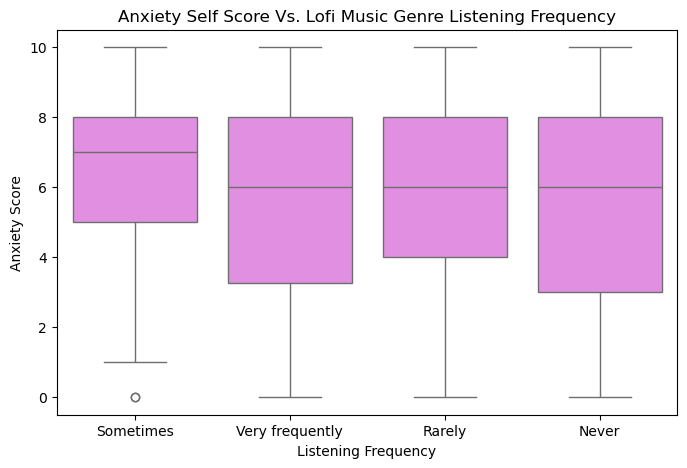

In [224]:
# Plotting the final association of the target variables using a boxplot
plt.figure(figsize=(8,5))

sns.boxplot(lofi_genre, x = "Lofi", y = "Anxiety", color = "violet")
plt.title("Anxiety Self Score Vs. Lofi Music Genre Listening Frequency")
plt.xlabel("Listening Frequency")
plt.ylabel("Anxiety Score");

The distribution of lofi listening frequency and anxiety scoring also shows little variation visually. The people who listen never, rarely, and very frequently all appear to have lower median anxiety scores than the people who only listen sometimes. The people who listen sometimes also have a higher minimum anxiety score and a possible outlier with an anxiety score of zero, like the metal plot. 

In [226]:
# Replacing categorical values with 0-3
lofi_genre["Lofi"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
lofi_genre.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3904807278.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lofi_genre["Lofi"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3904807278.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavi

,Lofi,Anxiety
2,2,7.0
3,2,9.0
4,2,7.0
5,3,8.0
6,1,4.0


In [227]:
# Assign X and y for linear regression
X_3 = lofi_genre[["Lofi"]]
y_3 = lofi_genre["Anxiety"]

# Build model
lm_3 = LinearRegression()
lm_fit_3 = lm_3.fit(X_3, y_3) # Fit model

In [228]:
# coefficient/slope
lm_fit_3.coef_

array([0.16960759])

In [229]:
# Intercept for model 3
lm_fit_3.intercept_

5.700003456039182

In [230]:
# Final summar for model 3 with p-value
X_3_sm = sm.add_constant(X_3)

lin_reg_3 = sm.OLS(y_3, X_3_sm).fit()
lin_reg_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Anxiety   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.493
Date:                Fri, 05 Dec 2025   Prob (F-statistic):              0.115
Time:                        00:01:47   Log-Likelihood:                -1497.3
No. Observations:                 616   AIC:                             2999.
Df Residuals:                     614   BIC:                             3007.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7000      0.161     35.423      0.000       5.384       6.016
Lofi           0.1696      0.107      1.579      0.115      -0.041       0.381
==============================================================================
Omnibus:                       49.849   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.897
Skew:                          -0.415   Prob(JB):                     1.95e-07
Kurtosis:                       2.282   Cond. No.                         2.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The last model I did was for Lofi listening frequency. Similar to the other models, how often a person listened to lofi only increased anxiety by 0.169, which is a small effect on a scale from 0-10. The frequency that a person listened to lofi only explained 0.4% of the variation in the data, like the rock model. The p-value I calculated for this model was 0.115, which means that I fail to reject the null hypothesis that the frequency a person listens to lofi does not affect the person's anxiety score. The confidence interval was -0.041 to 0.381, which again we cannot be confident in the effect the frequency of listening to lofi has on a person's anxiety. 

In conclusion, we fail to reject the null hypothesis for each model, and we can see that much of the variance in anxiety scores is explained by other variables than the music genres I chose. I tried to choose genres I thought might increase or decrease a person's anxiety while listening, so other genres might show more of an effect, or it's possible that there are other factors in the data set that could be explaining the variance. 

# Prediction

The first model I wanted to do for my prediction section was a simple regression model using the music genres from above, but adding in the hours per day a person listens to music to see if a person's listening habits could help explain any of their anxiety. I first needed to replace the values of the music genres with numerical values so they could be used in my regression model. I did this by using replace and then coding them to values 0-3 because they do have an order and ranking. Then I built my model by assigning the X, which was my predictor columns (music genres and hours per day), and y, which was my target column (anxiety score). I then used sklearn to split the dataset up into testing and training sets and then built my model, fit it, and then predicted the anxiety scores. I used mean squared error and mean absolute error to measure the success of my model. The mean squared error of 8.65 shows that the average squared distance between true values and predicted values is quite large, showing that my predicted values are not clustered tightly around the true values. The mean absolute error of 2.39 was quite large and shows that my prediction of anxiety scores is off by quite a bit, considering the anxiety scale is 0-10, and the prediction is off by about 2.39 points each time. 

## Simple Linear Regression

In [236]:
mmh_clean_copy = mmh_clean
#mmh_clean_copy.head()

mmh_clean_copy["Rock"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
mmh_clean_copy["Metal"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
mmh_clean_copy["Lofi"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
mmh_clean_copy.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/492693985.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mmh_clean_copy["Rock"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/492693985.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beha

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,R&B,Rap,Rock,Video game music,Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,1,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,0,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,0,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.
5,8/27/2022 21:56:50,18.0,Spotify,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,...,Very frequently,Very frequently,3,Never,8.0,8.0,7.0,7.0,Improve,I understand.
6,8/27/2022 22:00:29,18.0,YouTube Music,3.0,Yes,Yes,No,Video game music,Yes,Yes,...,Rarely,Never,0,Sometimes,4.0,8.0,6.0,0.0,Improve,I understand.


In [237]:
X = mmh_clean_copy[["Rock", "Metal", "Lofi", "Hours per day"]]
y = mmh_clean_copy["Anxiety"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  8.650537351459278
mean_absolute_error :  2.3968005098525884


## Multiple Linear Regression

Next, I wanted to do a model with multiple predictors. I started simple and then increased the predictors for each model. My first model used the original music genres (rock, metal, and lofi), then I added rap, classical, and pop. I first changed all the music genres to be numerical using .replace() and then trained my model. The mean squared error and mean absolute error were slightly better for this model than the simple linear regression model I did, but it was still quite high. The squared distance between my predicted values for anxiety and my true values was 7.61, which suggests that there was not a tight clustering around the true values for anxiety. My mean absolute error was still quite large; the model was predicting scores 2.33 off of the true anxiety scores, which, again, on a scale of 0-10, is quite a large error.

In [240]:
# encode genres first. Going to add a few more to this model. 
mmh_clean_copy["Rap"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
mmh_clean_copy["Classical"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
mmh_clean_copy["Pop"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
mmh_clean_copy.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3299821563.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mmh_clean_copy["Rap"].replace(["Never", "Rarely", "Sometimes", "Very frequently"], [0, 1, 2, 3], inplace=True)
/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/3299821563.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,R&B,Rap,Rock,Video game music,Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,1,1,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,0,0,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,3,0,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.
5,8/27/2022 21:56:50,18.0,Spotify,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,...,Very frequently,3,3,Never,8.0,8.0,7.0,7.0,Improve,I understand.
6,8/27/2022 22:00:29,18.0,YouTube Music,3.0,Yes,Yes,No,Video game music,Yes,Yes,...,Rarely,0,0,Sometimes,4.0,8.0,6.0,0.0,Improve,I understand.


In [241]:
X = mmh_clean_copy[["Rock", "Metal", "Lofi", "Rap", "Classical", "Pop"]] # Set X 
y = mmh_clean_copy["Anxiety"] # Set y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101) # Split

model = LinearRegression() # model 1
model.fit(X_train, y_train) # fitting
predictions = model.predict(X_test) # predicting 

print('mean_squared_error : ', mean_squared_error(y_test, predictions)) # errors
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  7.6126114130115425
mean_absolute_error :  2.3319050842222397


In [242]:
# Slightly better but we can do better

In [243]:
# Let's try genres plus some listening habits that people have like how much they listen and if they listen while working

# First we need to do one hot encoding I got this from geeks for geeks and followed their tutorial for linear regression 
predictor_df = mmh_clean_copy[["Anxiety", "Rock", "Metal", "Lofi", "Rap", "Classical", "Pop", "Hours per day"]]
categorical_columns = ["While working"]

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(mmh_clean_copy[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_columns))

# Reseting index because there was a mismatch somewhere and I was getting NA's
predictor_df = predictor_df.reset_index(drop=True) # Doesn't keep new index as a column and resets index to 0, 1, 2, 3... etc.
one_hot_df = one_hot_df.reset_index(drop=True) # Should have matching index now and fix NA problem

df_encoded = pd.concat([predictor_df, one_hot_df], axis=1)
df_encoded = df_encoded.drop("While working_No", axis=1)

df_encoded.head()
#df_encoded.isna().sum()

,Anxiety,Rock,Metal,Lofi,Rap,Classical,Pop,Hours per day,While working_Yes
0,7.0,1,2,2,1,0,1,4.0,0.0
1,9.0,0,0,2,0,2,2,2.5,1.0
2,7.0,0,0,2,3,0,2,4.0,1.0
3,8.0,3,1,3,3,1,3,5.0,1.0
4,4.0,0,1,1,0,2,1,3.0,1.0


In [244]:
# Now we can build our model
X = df_encoded[["Rock", "Metal", "Lofi", "Rap", "Classical", "Pop", "Hours per day", "While working_Yes"]]
y = df_encoded["Anxiety"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 102)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  6.0282076028201095
mean_absolute_error :  1.9761865176610958


This model was better than the simple linear regression model I first built and the music genre-only model I built. I used one one-hot encoder to encode the variables that were non-numeric. I looked this up, and I'm not sure this was actually necessary. I think I could've just continued using replace as I did above, but I was following a tutorial from Geeks for Geeks. I didn't use it for my logistic regression model after learning that it's not needed for ordinal or distinct category columns (like "yes"/"no" or "male"/"female"). The mean squared error I calculated for this model was 6.02, which was the lowest of all four of the linear regression models, but it is still quite large, suggesting that the distance between the predicted and true anxiety scores is still large. In addition, the absolute error was lower, 1.97, but in the context of an anxiety scale between 0-10, the predicted values being 1.96 scores off the true values is still not good. 

In [246]:
# Now lets do a full model with Extra features describing the person

# Start with encoding again
predictor_df = mmh_clean_copy[["Anxiety", "Rock", "Metal", "Lofi", "Rap", "Classical", "Pop", "Hours per day", "Age"]]
categorical_columns = ["While working", "Composer", "Instrumentalist"]

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(mmh_clean_copy[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_columns))

# Reseting index because there was a mismatch somewhere and I was getting NA's
predictor_df = predictor_df.reset_index(drop=True) # Doesn't keep new index as a column and resets index to 0, 1, 2, 3... etc.
one_hot_df = one_hot_df.reset_index(drop=True) # Should have matching index now and fix NA problem

df_encoded = pd.concat([predictor_df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(["While working_No", "Composer_No", "Instrumentalist_No"], axis=1)

df_encoded.head()
#df_encoded.isna().sum()

,Anxiety,Rock,Metal,Lofi,Rap,Classical,Pop,Hours per day,Age,While working_Yes,Composer_Yes,Instrumentalist_Yes
0,7.0,1,2,2,1,0,1,4.0,18.0,0.0,0.0,0.0
1,9.0,0,0,2,0,2,2,2.5,61.0,1.0,1.0,0.0
2,7.0,0,0,2,3,0,2,4.0,18.0,1.0,0.0,0.0
3,8.0,3,1,3,3,1,3,5.0,18.0,1.0,1.0,1.0
4,4.0,0,1,1,0,2,1,3.0,18.0,1.0,0.0,1.0


In [247]:
# Now fit the model again 
X = df_encoded[["Rock", "Metal", "Lofi", "Rap", "Classical", "Pop", "Hours per day", "Age", "While working_Yes", "Composer_Yes", "Instrumentalist_Yes"]]
y = df_encoded["Anxiety"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 103)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  7.9437484304055275
mean_absolute_error :  2.2860829192320007


In [248]:
# Interesting this model is not better than model 2. 

This was my final linear regression model. Here, I basically included music genres, a person's listening habits, like whether they listen while working and how many hours a day they listen, and then I also included descriptive factors about the person, like age, if they were a composer or instrumentalist. This model was not better than the second model, with a squared distance between the true values and predicted values of 7.94, and the predicted values were off by about 2.28 points from the true values. None of my linear regression models were that good at predicting anxiety scores, but it was still good information! The models just showed that there are hundreds of factors that affect a person's anxiety level, and that makes it difficult to predict. These factors are also likely not in the data set, so that's also good to know! 

## Logistic Regression

In [251]:
# What if I tried looking at classifying whether music improves or has no effect on mental health based on a person's listening habits

After my linear regression models weren't great, I wanted to keep trying, so I thought I could try and predict the effect on a person's mental health. This column had three values, but for simplicity, I looked it up, and it said to just combine them into two, which was improve or no effect. I essentially just combined worsen and no effect into one because, also looking at the unique values, there were only 15 people who said worsen and only 136 that said no effect vs 465 that said improve. I then changed these values into 1 for improvement and 0 for no effect/worse. I also followed a Geeks for Geeks tutorial for this to help build the model and graph the model. I also decided to basically use all the features from the last model I did for the simple linear regression model, I'm not sure why I just wanted to start with all of them. 

In [253]:
mmh_clean["Music effects"].unique()

array(['No effect', 'Improve', 'Worsen'], dtype=object)

In [254]:
# Let's start with just binary classication to build a simple model first. Target will be improve as 1 and no effect or worsen will be 0.

In [255]:
# First we need to change the target column "Music effects" into binary 1 and 0.

# Checking that there's a good number of values for each answer
mmh_clean["Music effects"].value_counts()

Music effects
Improve      465
No effect    136
Worsen        15
Name: count, dtype: int64

In [256]:
predictor_col_df = mmh_clean_copy[["Rock", "Metal", "Lofi", "Rap", "Classical", "Pop",
                                   "Age", "Hours per day", "While working", "Instrumentalist", "Composer", "Music effects"]]
#predictor_col_df.head()

# Now change the values to 1 and 0 using mmh_clean_copy again to avoid altering the original data frame
predictor_col_df["Music effects"] = predictor_col_df["Music effects"].replace(["Improve", "No effect", "Worsen"], [1, 0, 0])
# Replace all other categorical columns "Yes", "No" with 0 and 1
predictor_col_df = predictor_col_df.replace(["Yes", "No"], [1, 0])
predictor_col_df.head()

/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/2775627193.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictor_col_df["Music effects"] = predictor_col_df["Music effects"].replace(["Improve", "No effect", "Worsen"], [1, 0, 0])
/var/folders/_k/lb15blsd3qb04yljpcpq59_m0000gn/T/ipykernel_54376/2775627193.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor_col_df["Music effects"] = predictor_col_df["Music effects"].replace(["Improve", "No effect", "Worsen"], [1, 0, 0])
/var/folders/_k/lb

,Rock,Metal,Lofi,Rap,Classical,Pop,Age,Hours per day,While working,Instrumentalist,Composer,Music effects
2,1,2,2,1,0,1,18.0,4.0,0,0,0,0
3,0,0,2,0,2,2,61.0,2.5,1,0,1,1
4,0,0,2,3,0,2,18.0,4.0,1,0,0,1
5,3,1,3,3,1,3,18.0,5.0,1,1,1,1
6,0,1,1,0,2,1,18.0,3.0,1,1,0,1


In [257]:
X = predictor_col_df.drop("Music effects", axis=1).reset_index(drop=True)
y = predictor_col_df["Music effects"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=104)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy * 100, "%")

Accuracy:  77.41935483870968 %


In [258]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred)) # Got this from Geeks for Geeks to print confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 1 26]
 [ 2 95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.04      0.07        27
           1       0.79      0.98      0.87        97

    accuracy                           0.77       124
   macro avg       0.56      0.51      0.47       124
weighted avg       0.69      0.77      0.70       124



My accuracy looked pretty good at first at 77.419% and I was feeling pretty confident, but then I got the entire confusion matrix and realized that my model was only predicting improvement (1) well, which makes sense considering the sample size of improved mental health is much larger than no effect/worsen (0). There were 95 correctly predicted improvements in mental health, but only 1 correct prediction for no effect/worsen, and 26 incorrect predictions; my accuracy for this class was only 33%. While the model looked good at first, I could see from the full results that it was really only doing well on the class with the most samples and was really failing on the class with the smaller amount of samples. I looked up what could be done about this and asked ChatGPT, and it suggested I use a weight to balance out the sample size, so I built the model again with ChatGPT's suggestion. 

In [260]:
lr_model = LogisticRegression(class_weight="balanced", max_iter=1000) # Same model but with a weight
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy * 100, "%")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy:  64.51612903225806 %
Confusion Matrix:
 [[16 11]
 [33 64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.59      0.42        27
           1       0.85      0.66      0.74        97

    accuracy                           0.65       124
   macro avg       0.59      0.63      0.58       124
weighted avg       0.74      0.65      0.67       124



This time the accuracy was not as good at 64.51% but when you look a the entire confusion matrix, you can see that it's actually predicting the smaller no effect/worsen class better. This time, there were 16 that the model was predicting correctly and 11 that it was falsely predicting as 11, which is still high. The precision was still low at 33% for class 0, and it was higher for class 1 at 85%. 

In [262]:
# Next plot AUC and ROC curve

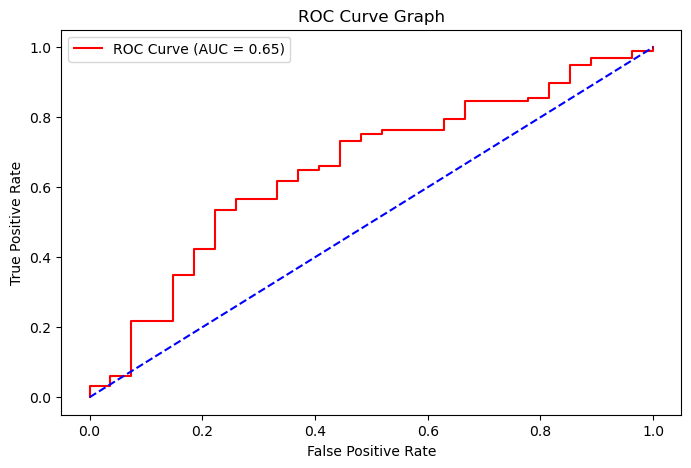

In [270]:
plt.figure(figsize=(8,5))

y_prob = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color = "blue", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Graph")
plt.legend();

In the end, these models all showed that the variables I had in the data frame were not the ones that had the most correlation with anxiety scores. Anxiety is a complex mental health disorder that has a lot of factors that play into its severity, and it's truly unique for each individual. I knew that this would be a complicated variable to predict, but I thought I would still try! This is also true for whether music improves or worsens a person's mental health, as this variable is very subjective and each person has their own idea on how they believe music affects them, even if that's not necessarily "true". I think it would be interesting to try and improve the logistic regression model by evaluating which predictors are helping or what aren't, or maybe try another model like random forest next. I still had fun with this project, even if I didn't really successfully infer or predict anything about how music affects a person's mental health. Personally, I find that music does help me, and I think maybe that's really all the evidence I need to keep listening to music for my mental health, haha!  